In [17]:
import re
import os
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

from scipy.integrate import solve_ivp
from scipy.linalg import solve
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve, inv

%matplotlib inline

# Exercise 3: Sparse Matrices, Static and Transient Problem of Governor

(a) The mass and stiffness matrices were exported from Ansys in the Harwell-Boeing format for sparse matrices. Write a function to import the matrices located in the files M_L.txt and K_L.txt.

In [18]:
def conv(value):
    try:
        return float(value)
    except ValueError:
        return float(re.sub(r"D", 'E', str(value, 'utf-8')))

def read_hb(file_path):
    with open(file_path) as file:
        # First line
        line = file.readline().strip("\n")
        if not len(line) > 72:
            raise ValueError("Expected at least 72 characters for first line, "
                             "got: \n%s" % line)
        title = line[:72]
        key = line[72:]

        # Second line
        line = file.readline().strip("\n")
        if not len(line.rstrip()) >= 56:
            raise ValueError("Expected at least 56 characters for second line, "
                         "got: \n%s" % line)
        total_nlines = int(line[:14])
        pointer_nlines = int(line[14:28])
        indices_nlines = int(line[28:42])
        values_nlines = int(line[42:56])

        data = np.loadtxt(file_path, skiprows=5, converters={0: conv})

        indptr = data[:pointer_nlines].astype(int) - 1
        indices = data[pointer_nlines:pointer_nlines + indices_nlines].astype(int) - 1
        values = data[pointer_nlines + indices_nlines:pointer_nlines + indices_nlines + values_nlines]

        sparse_matrix = csc_matrix((values, indices, indptr))

        # Symmetrization of scipy sparse matrices
        rows, cols = sparse_matrix.nonzero()
        sparse_matrix[cols, rows] = sparse_matrix[rows, cols]

    return sparse_matrix

Execute function ```read_hb```.

In [19]:
resources_path = os.path.join('resources')
K_L_path = os.path.join(resources_path, 'K_L.txt')
M_L_path = os.path.join(resources_path, 'M_L.txt')

K_txt = read_hb(K_L_path)
M_txt = read_hb(M_L_path)

C:\Users\Jonas\anaconda3\envs\MRoMS\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Compare the results with the already imported matrices

In [20]:
from pymatreader import read_mat

def read_hb_from_mat(file_path, name):
    mat_dic = read_mat(file_path)[name]
    indptr = mat_dic['jc']
    indices = mat_dic['ir']
    values = mat_dic['data']
    return csc_matrix((values, indices, indptr))

def is_equal(sparse_A, sparse_B):
    return np.allclose(sparse_A.A, sparse_B.A)

In [21]:
K_mat_path = os.path.join(resources_path, 'K.mat')
M_mat_path = os.path.join(resources_path, 'M.mat')

K_mat = read_hb_from_mat(K_mat_path, 'K')
M_mat = read_hb_from_mat(M_mat_path, 'M')

# Equality check
print(f'The equality check of K_txt and K_mat results in {is_equal(K_txt, K_mat)}')
print(f'The equality check of M_txt and M_mat results in {is_equal(M_txt, M_mat)}')

The equality check of K_txt and K_mat results in True
The equality check of M_txt and M_mat results in True


Alternatively and recommended use already implemented functions
`scipy.io.hb_read & scipy.io.hb_write`.

In [22]:
from scipy.io.harwell_boeing import hb_read, hb_write
K_hb_path = os.path.join(resources_path, 'K.hb')
M_hb_path = os.path.join(resources_path, 'M.hb')
hb_write(M_hb_path, M_mat)
hb_write(K_hb_path, K_mat)

M_hb = hb_read(M_hb_path)
K_hb = hb_read(K_hb_path)

# Equality check
print(f'The equality check of K_hb and K_mat results in {is_equal(K_hb, K_mat)}')
print(f'The equality check of M_hb and M_mat results in {is_equal(M_hb, M_mat)}')

with open(M_hb_path, 'r') as f:
    print(f.read())

The equality check of K_hb and K_mat results in True
The equality check of M_hb and M_mat results in True
Default title                                                           0       
          6566            43           851          5672
RUA                      552           552         17016             0
(13I6)          (20I4)          (3E25.16)           
     1    52   103   154   186   218   250   270   290   310   342   374   406
   457   508   559   591   623   655   675   695   715   747   779   811   843
   875   907   927   947   967   987  1007  1027  1059  1091  1123  1155  1187
  1219  1239  1259  1279  1299  1319  1339  1371  1403  1435  1486  1537  1588
  1620  1652  1684  1704  1724  1744  1776  1808  1840  1872  1904  1936  1956
  1976  1996  2028  2060  2092  2112  2132  2152  2184  2216  2248  2268  2288
  2308  2328  2348  2368  2400  2432  2464  2484  2504  2524  2544  2564  2584
  2616  2648  2680  2700  2720  2740  2791  2842  2893  2925  2957  2989  3040


(b) Plot the sparsity pattern of the matrices with the Matlab function spy.
Using `matplotlib.pylab.spy`.

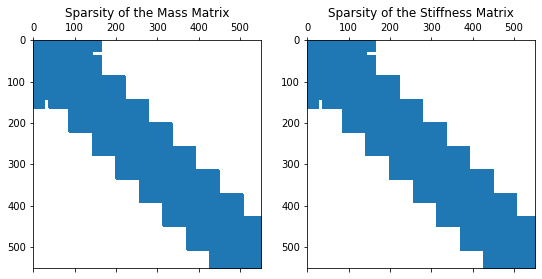

In [23]:
M = M_txt.copy()
K = K_txt.copy()

fig, axes = plt.subplots(figsize=(9, 9), nrows=1, ncols=2,)
ax = axes.ravel()
ax[0].spy(M)
ax[0].set_title("Sparsity of the Mass Matrix")
ax[1].spy(K)
ax[1].set_title("Sparsity of the Stiffness Matrix")
plt.show()

(c) Apply the same constraints to the system as in the Ansys example `
from the lecture, i.e. Dirichlet conditions in all directions at
nodes 27,28,29,48,49,50. Use the following table to find the corresponding
degrees of freedom in the displacement vector u:

| node  | 27 | 28 | 29 | 47 | 48 | 49 | 50 | 51 |
| ----- |----|----|----|----|----|----|----|----|
| x     | 502| 505| 535|  64| 532| 499| 496|   4|
| y     | 503| 506| 536|  65| 533| 500| 497|   5|
| z     | 504| 507| 537|  66| 534| 501| 498|   6|

In [24]:
def apply_dirichlet_conditions(A, indices):
    A_dense = A.A
    A_dense = np.delete(A_dense, indices, axis=0)
    A_dense = np.delete(A_dense, indices, axis=1)

    return csc_matrix(A_dense)

In [25]:
dirichlet_indices = np.array(
    [502, 503, 504,
     505, 506, 507,
     535, 536, 537,
     532, 533, 534,
     499, 500, 501,
     496, 497, 498]) - 1

K = apply_dirichlet_conditions(K, dirichlet_indices)
M = apply_dirichlet_conditions(M, dirichlet_indices)

print(f'Mass matrix before dirichlet had {len(M_txt.data)} entries, '
      f'after dirichlet {len(M.data)}')
print(f'Stiffness matrix before dirichlet had {len(K_txt.data)} entries, '
      f'after dirichlet {len(K.data)}')

Mass matrix before dirichlet had 17016 entries, after dirichlet 16236
Stiffness matrix before dirichlet had 49032 entries, after dirichlet 46804


(d) Solve the static problem `K · u = f` with a force `f` applied on
nodes 47 and 51 in y-direction with `100 N` each.
The imported mechanical system uses the SI unit system.
Solve the system of linear equations once with full matrices
and once with sparse matrices.
Which method is used each time by Matlab?
What numerical libraries are used by Matlab each time?

    (i) for sparse matrices scipy.sparse.linalg.spsolve(A, b)
        Solve the sparse linear system Ax=b, where b may be a vector or a matrix.

In [26]:
order = K.shape[0]

force_indices = np.array([65, 5]) - 1

f = csc_matrix((order, 1))
f[force_indices] = 100

start_time = time.time()
u_sparse = spsolve(K, f)
end_time_sparse = time.time() - start_time

print(f'Linear System solved for sparse matrices in {end_time_sparse:.4f}s.')

Linear System solved for sparse matrices in 0.0030s.


    (i) for full matrices scipy.linalg.solve(a, b)
        Solve the equation a x = b for x.

In [27]:
K_full = K.A
f_full = f.A

start_time = time.time()
u_full = solve(K_full, f_full)
end_time_full = time.time() - start_time

print(f'Linear System solved for full matrices in {end_time_full:.4f}s.')


Linear System solved for full matrices in 0.0130s.


(e) Solve the transient problem:

\begin{equation*}
\mathbf{M} \cdot \mathbf{\ddot{u}(t)} +\, \mathbf{K} \cdot \mathbf{u(t)} = \mathbf{f(t)}
\end{equation*}

with f a 1 Hz sinus oscillation on nodes 47 and 51 in y-direction
with an amplitude of 0.01 N in the time domain [0, 2].
Plot the displacement in x-direction of node 47 over time
and compare it with the plot full_transient_node_47.png provided by us.

In [28]:
def f_factory(f0, frequency=1, amplitude=0.01, V=None):
    if V is not None:
        force_fcn = lambda t: np.transpose(V) @ f0 * amplitude * np.sin(2 * np.pi * frequency * t)
    else:
        force_fcn = lambda t: f0 * amplitude * np.sin(2 * np.pi * frequency * t)
    return force_fcn


def ode_f(t, x, M, K, f_fcn):
    u, dudt = x.reshape((2, -1))

    dxdt = np.concatenate((dudt, spsolve(M, f_fcn(t) - K @ u)))

    return dxdt

png_name = 'full_transient_node_47.png'
png_path = os.path.join(resources_path, png_name)
sol_image = imread(png_path)

Integrate the ode using
`scipy.integrate.solve_ivp`

In [29]:
time_domain = [0, 2]
x0 = np.zeros(2 * order)

force_indices = np.array([65, 5]) - 1
f0 = np.zeros(order)
f0[force_indices] = 1

f_fcn = f_factory(f0)

# start_time = time.time()
# ivp_sol_full = solve_ivp(ode_f, time_domain, x0, method='RK23', args=(M, K, f_fcn))
# time_full = time.time() - start_time

(f) We provide you with a reduction matrix V containing the first 10 eigenmodes of the constraint
system. The reduced system is built with a Petrov-Galerkin projection:


C:\Users\Jonas\anaconda3\envs\MRoMS\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


Transient problem solved for reduced system in 39.9828s.


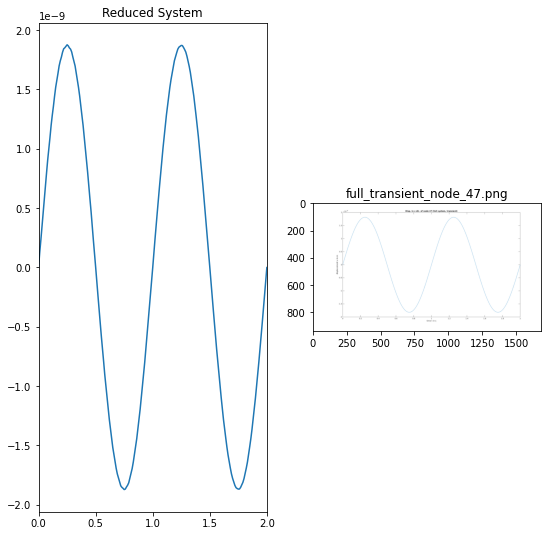

In [30]:
V_path = os.path.join(resources_path, 'V.mat')
V = read_mat(V_path)['V']

red_order = V.shape[1]

f_fcn_red = f_factory(f0, 1, 0.01, V)

M_red = np.transpose(V) @ M @ V
K_red = np.transpose(V) @ K @ V

t_end = 2
t_step = 0.01
t_eval = np.arange(0, t_end + t_step, t_step)

x0_red = np.zeros(2 * red_order)

start_time = time.time()
ivp_sol_red = solve_ivp(ode_f, (0, t_end), x0_red, method='RK23', t_eval=t_eval, args=(M_red, K_red, f_fcn_red))
time_red = time.time() - start_time
print(f'Transient problem solved for reduced system in {time_red:.4f}s.')

u_red = V @ ivp_sol_red.y[:red_order, :]

fig, axes = plt.subplots(figsize=(9, 9), nrows=1, ncols=2,)
ax = axes.ravel()
ax[0].plot(t_eval, u_red[63, :])
ax[0].set_xlim(0.0, 2)
ax[0].set_title("Reduced System")
ax[1].imshow(sol_image)
ax[1].set_title(png_name)
plt.show()

(g) Compare the full and reduced solution by a reasonable method of your choice.
